# **Libraries and Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

# from pyDOE2 import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [3]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Random Testing**

In [ ]:
a = torch.tensor(np.ones(shape=(3,1)), requires_grad=True).float().to(device)
b = torch.tensor(np.zeros(shape=(3,1)), requires_grad=True).float().to(device)

In [ ]:
print((-3+a)**2)

tensor([[4.],
        [4.],
        [4.]], device='cuda:0', grad_fn=<PowBackward0>)


In [ ]:
layers_test = [1, 100, 2]
dnn = DNN(layers_test).to(device)

test_in = torch.tensor(np.ones(shape=(101,1)), requires_grad=True).float().to(device)
out = dnn(test_in)
print(out)

u = dnn(test_in)
print(u.shape)
o1, o2 = u[:, 0], u[:, 1]

print(o1)
print(o1.shape)

xt = torch.autograd.grad(
    u[:,0], test_in,
    grad_outputs=torch.ones_like(u[:,0]),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
)[0]

pt = torch.autograd.grad(
    u[:,1], test_in,
    grad_outputs=torch.ones_like(u[:,1]),
    retain_graph=True,
    create_graph=True,
    allow_unused=True
)[0]

In [ ]:
o1_new = o1.unsqueeze(0).T
print(o1_new.shape)
print(o1_new)

In [ ]:
ub_test = 1.0
ub_torch = torch.tensor([ub_test], requires_grad=True).float().to(device)

xf_test = 1.0
xf_torch = torch.tensor([xf_test], requires_grad=True).float().to(device)

In [ ]:
print(ub_torch.shape)

torch.Size([1])


In [ ]:
ub_test = 1.0
ub_torch = torch.tensor([ub_test], requires_grad=True).float().to(device)

xf_test = 1.0
xf_torch = torch.tensor([xf_test], requires_grad=True).float().to(device)

layers_test = [1, 100, 2]
dnn = DNN(layers_test).to(device)

out_test = dnn(ub_torch)

print(out_test)

tensor([ 0.0777, -0.0432], device='cuda:0', grad_fn=<AddBackward0>)


# **Physics-informed Neural Networks**

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(layer.weight.data, gain=1.0)
            torch.nn.init.zeros_(layer.bias.data)

            layer_list.append(
                ('layer_%d' % i, layer)
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            # layer_list.append(('dropout_%d'%i, torch.nn.Dropout(0.005)))

            # layer_list.append(('normalisation_%d' % i, torch.nn.BatchNorm1d(layers[i+1])))
            # layer_list.append(('normalisation_%d' % i, torch.nn.layerNorm(layers[i+1])))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_f, X_u, U_u, P_u, layers, t0, tf, x0, xf, T, X, U, P):

        #random seeds
        self.lhs_rs = 0
        torch.manual_seed(0)
        np.random.seed(1234)  

        self.num_u = X_u.shape[0]
        self.num_f = t_f.shape[0]

        # data
        self.x_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u_u = torch.tensor(U_u, requires_grad=True).float().to(device)
        self.p_u = torch.tensor(P_u, requires_grad=True).float().to(device)

        self.t_f = torch.tensor(t_f, requires_grad=True).float().to(device)

        # initial and final points for loss
        self.t0 = torch.tensor([t0], requires_grad=True).float().to(device)
        self.tf = torch.tensor([tf], requires_grad=True).float().to(device)

        self.x0 = torch.tensor([x0], requires_grad=True).float().to(device)
        self.xf = torch.tensor([xf], requires_grad=True).float().to(device)

        # Testing data set
        self.T = torch.tensor(T, requires_grad=True).float().to(device)
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.U = torch.tensor(U, requires_grad=True).float().to(device)
        self.P = torch.tensor(P, requires_grad=True).float().to(device)

        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(self.layers).to(device)
        
        # optimizers: using the same settings
        self.optim_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=20, 
            max_eval=20, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        # optimizers: using the same settings
        self.optim_adam = torch.optim.Adam(
            self.dnn.parameters(),
            lr=0.001,
            eps=1e-08,
            weight_decay=0,
            amsgrad=False
        )

        self.num_epochs_lbfgs = 500
        self.num_epochs_adam = 10000
        
        self.iter = 0 

    def net_u(self, t):
        dnn_out = self.dnn(t)
        return dnn_out

    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        
        print("inside net_f..")
        out = self.net_u(t)
        print(f"shape of out: {out.shape}")
        x_pred, p_pred = out[:, 0].unsqueeze(0).T, out[:, 1].unsqueeze(0).T
        print(f"shape of x_pred: {x_pred.shape} || shape of p_pred: {p_pred.shape}")
        
        dx_dt = torch.autograd.grad(
            x_pred, t,
            grad_outputs=torch.ones_like(x_pred),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        dp_dt = torch.autograd.grad(
            p_pred, t, 
            grad_outputs=torch.ones_like(p_pred),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        print(f"shape of dx_dt: {dx_dt.shape} || shape of dp_dt: {dp_dt.shape}")
        
        f_pred1 = dx_dt + x_pred + p_pred
        f_pred2 = dp_dt - p_pred + x_pred

        print(f"f_pred1 shape: {f_pred1.shape}")
        print(f"f_pred2 shape: {f_pred2.shape}")

        loss_f = torch.mean(f_pred1 ** 2) + torch.mean(f_pred2 ** 2)

        print(f"loss_f shape: {loss_f.shape}")

        # # errors in x and p
        # self.error_x = torch.mean((self.X - x_pred)**2)
        # self.error_p = torch.mean((self.P - p_pred)**2)

        # print(f"error_x shape: {self.error_x.shape} || error_p shape: {self.error_p.shape}")

        # print(
        #     f'Iter {self.iter}, x_error: {self.error_x}, p_error: {self.error_p}'
        # )

        return loss_f
    
    def loss_func_ocp(self):

        global train_error
        
        self.optim_lbfgs.zero_grad()
        
        # initial and final predictions
        x0_pred = self.net_u(self.t0)[0]
        xf_pred = self.net_u(self.tf)[0]

        print(f"x0_pred shape: {x0_pred.shape} || xf_pred shape: {xf_pred.shape}")

        self.loss_f = self.net_f(self.t_f)
        self.loss_init = torch.mean((self.x0 - x0_pred)**2)
        self.loss_final = torch.mean((self.xf - xf_pred)**2)

        print(f"loss_f shape: {self.loss_f.shape}")
        print(f"loss_init shape: {self.loss_init.shape}")
        print(f"loss_final shape: {self.loss_final.shape}")

        self.loss = self.loss_f + self.loss_init + self.loss_final

        print(f"total loss shape: {self.loss.shape}")

        self.loss.backward()

        self.iter += 1
        # if self.iter % 100 == 0:
        print(
            f'Iter {self.iter}, Total_loss: {self.loss.item()}, Loss_f: {self.loss_f.item()}, Loss0: {self.loss_init}, Loss1: {self.loss_final}'
        )
        
        train_error.append(self.loss.item())

        return self.loss
    
    def vanilla_train(self):
        # set the model training mode "on"
        self.dnn.train()

        for epoch_index in range(self.num_epochs_lbfgs):
            print(f"\nIter: {self.iter}")
            self.optim_lbfgs.step(self.loss_func_ocp)
    
            
    def predict(self, T_test):

        self.dnn.eval()
        test_out = self.net_u(T_test)
        x_test, p_test = test_out[:,0], test_out[:,1]

        self.error_x = torch.mean((self.X - x_test)**2)
        self.error_p = torch.mean((self.P - p_test)**2)
        
        print(f"error x: {self.errro_x}")
        print(f"error p: {self.errro_p}")
        
        return None

# **Configurations**

In [6]:
############################ Hypersensitive Problem data loading #########################

noise = 0.0

train_error = []
test_error = []

N_u = 10
N_f = 101

n_neurs = 25
layers = [1, n_neurs, n_neurs, n_neurs, n_neurs, 2]

data = scipy.io.loadmat('/content/drive/MyDrive/SEM - 7/BTP/Phase-2/data/hypersensitive_data.mat')

t0 = 0.0
tf = 1.0
x0 = 1.5
xf = 1.0

t_f = np.expand_dims(np.arange(N_f, dtype = np.float64) / (N_f - 1), axis=1)

t = data['t'].flatten()[:,None]
x = data['x_data'].flatten()[:,None]
u = data['u_data'].flatten()[:, None]
p = data['p_data'].flatten()[:, None]

print("type of t_f: {} || shape: {}".format(type(t_f), t_f.shape))
print("type of t: {} || shape: {}".format(type(t), t.shape))
print("type of x: {} || shape: {}".format(type(x), x.shape))
print("type of u: {} || shape: {}".format(type(u), u.shape))
print("type of p: {} || shape: {}".format(type(p), p.shape))

# supervised learning
idx = np.random.choice(t.shape[0], N_u, replace=False)

x_train = x[idx, :]
u_train = u[idx, :]
p_train = p[idx, :]

type of t_f: <class 'numpy.ndarray'> || shape: (101, 1)
type of t: <class 'numpy.ndarray'> || shape: (10001, 1)
type of x: <class 'numpy.ndarray'> || shape: (10001, 1)
type of u: <class 'numpy.ndarray'> || shape: (10001, 1)
type of p: <class 'numpy.ndarray'> || shape: (10001, 1)


# **Training**

In [7]:
model = PhysicsInformedNN(t_f, x_train, u_train, p_train, layers, t0, tf, x0, xf, t, x, u, p)

In [8]:
%%time

model.vanilla_train()

Streaming output truncated to the last 5000 lines.
loss_final shape: torch.Size([])
total loss shape: torch.Size([])
Iter 789, Total_loss: 6.198824564762617e-08, Loss_f: 6.198220603437221e-08, Loss0: 5.130118552187923e-12, Loss1: 9.094947017729282e-13

Iter: 789
x0_pred shape: torch.Size([]) || xf_pred shape: torch.Size([])
inside net_f..
shape of out: torch.Size([101, 2])
shape of x_pred: torch.Size([101, 1]) || shape of p_pred: torch.Size([101, 1])
shape of dx_dt: torch.Size([101, 1]) || shape of dp_dt: torch.Size([101, 1])
f_pred1 shape: torch.Size([101, 1])
f_pred2 shape: torch.Size([101, 1])
loss_f shape: torch.Size([])
loss_f shape: torch.Size([])
loss_init shape: torch.Size([])
loss_final shape: torch.Size([])
total loss shape: torch.Size([])
Iter 790, Total_loss: 6.198824564762617e-08, Loss_f: 6.198220603437221e-08, Loss0: 5.130118552187923e-12, Loss1: 9.094947017729282e-13

Iter: 790
x0_pred shape: torch.Size([]) || xf_pred shape: torch.Size([])
inside net_f..
shape of out: to

In [9]:
# performance of the model

# model.predict()

model.dnn.eval()
test_out = model.net_u(model.T)
x_test, p_test = test_out[:,0].unsqueeze(0).T, test_out[:,1].unsqueeze(0).T

model.error_x = torch.mean((model.X - x_test)**2)
model.error_p = torch.mean((model.P - p_test)**2)

print(f"error x: {model.error_x}")
print(f"error p: {model.error_p}")

error x: 2.537348109399318e-10
error p: 7.253574130228202e-11


In [10]:
tf = torch.tensor([0.636522], requires_grad=True).float().to(device)

test_out = model.net_u(tf)
x_test, p_test = test_out[0], test_out[1]

print(x_test, p_test)

tensor(0.9469, device='cuda:0', grad_fn=<SelectBackward0>) tensor(-0.7500, device='cuda:0', grad_fn=<SelectBackward0>)


# **Visualizations**

Text(0.5, 1.0, 'train_error error')

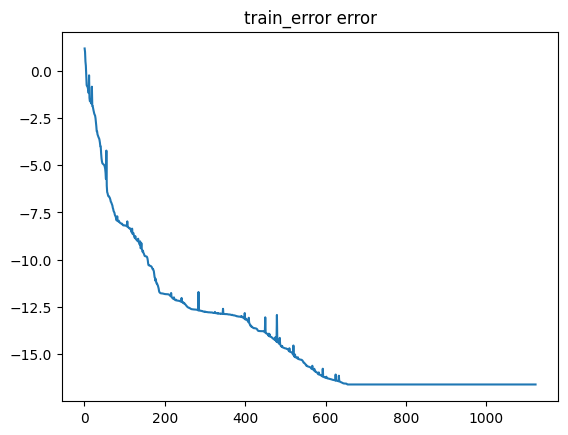

In [11]:
import matplotlib

x_axis = [i for i in range(1,len(train_error)+1)]

new_train_error = np.log(train_error)
plt.plot(x_axis, new_train_error)
# plt.ylim(1e-4, 1)
plt.title("train_error error")